In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import beta

from matplotlib import font_manager

font_dirs = ["/home/hblee/.conda/envs/jax_main/fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["mathtext.fontset"] = 'cm'

import jax
import jax.numpy as jnp
from flax.training import train_state
import optax

import tskit
import msprime

from model import PhyloBetaLoss

from typing import Any, Callable, Sequence

In [2]:
# simulate latent
def simulate_state(t0, rate, num_sequences):
    x0 = np.random.binomial(n=1, p=.5)
    p1 = (1 + (2*x0-1) * np.exp(-rate*t0)) * .5
    x1 = np.random.binomial(n=1, p=p1, size=1)
    p2 = (1 + (2*x1-1) * np.exp(-rate*(1-t0))) * .5
    x2 = np.random.binomial(
        n=1,
        p=p2,
        size=num_sequences
    )
    return x2

def simulate_state_batch(t0, rate, num_sequences, num_batch=1):
    out = np.empty((num_batch, num_sequences))
    for i in range(num_batch):
        out[i] = simulate_state(t0, rate, num_sequences)
    return out

In [6]:
key = jax.random.PRNGKey(2)
t, rate, num_sequences = .5, .1, 100
num_batch = 100
arr = simulate_state_batch(t, rate, num_sequences, num_batch)
model = PhyloBetaLoss()
params = model.init(key, arr.T)
params

{'params': {'a': Array([1.], dtype=float32), 'b': Array([1.], dtype=float32)}}

In [8]:
optimizer  = optax.adam(learning_rate=0.01)
phylobeta_state = train_state.TrainState.create(apply_fn=model.apply,
                                               params=params,
                                               tx=optimizer)
@jax.jit  # Jit the function for efficiency
def train_step(state, arr):
    grad_fn = jax.value_and_grad(state.apply_fn,  
                                 argnums=0,  
                                 has_aux=False)
    loss, grads = grad_fn(state.params, arr)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, arr, num_epochs=500):
    for epoch in range(num_epochs):
        state, loss = train_step(state, arr)
    return state, loss

In [20]:
t, rate, num_sequences = .9, .2, 500
num_batch = 10

num_sim = 2000
bs = np.empty((num_sim, 2))
for i in range(num_sim):
    arr = simulate_state_batch(t, rate, num_sequences, num_batch)
    # glm git
    b_glm = sm.GLM(arr.ravel(), np.ones(arr.ravel().size), family=sm.families.Binomial()).fit().params
    # phylo fit
    phylobeta_state_trained, _ = train(
        phylobeta_state, 
        jnp.array(arr.T, dtype=jnp.float32))
    a = phylobeta_state_trained.params['params']['a']
    b = phylobeta_state_trained.params['params']['b']
    
    bs[i] = [np.array(a / (a + b))[0], (np.exp(b_glm) / (1 + np.exp(b_glm)))[0]]

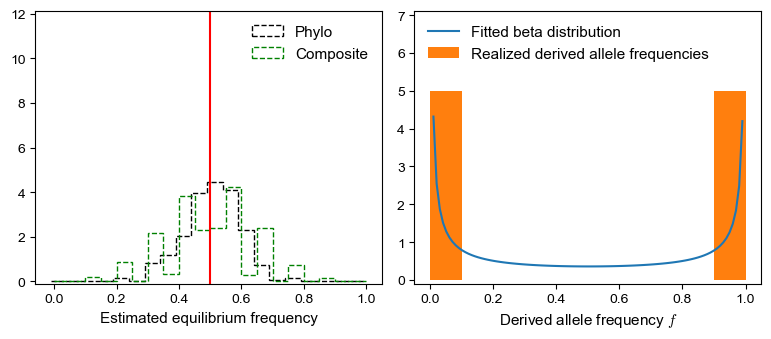

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# standard error
ax[0].hist(bs[:,0], bins=np.linspace(-0.01,0.99,21), density=True, edgecolor='black', histtype=u'step', ls='--', label='Phylo')
ax[0].hist(bs[:,1], bins=np.linspace(0,1,21), density=True, edgecolor='green', histtype=u'step', ls='--', label='Composite')
ax[0].legend(frameon=False, fontsize=11)
ax[0].axvline(0.5, color='red')
ax[0].set_xlabel("Estimated equilibrium frequency", fontsize=11)
ax[0].set_ylim([-.1, 12.1])

# beta fit
x = np.linspace(0, 1, 100)
pdf = beta.pdf(x, a, b)

ax[1].plot(x, pdf, label='Fitted beta distribution')
ax[1].hist(arr.mean(axis=1), density=True, label='Realized derived allele frequencies', bins=np.linspace(0,1,11))
ax[1].legend(loc=2, frameon=False, fontsize=11)
ax[1].set_xlabel(r"Derived allele frequency $f$", fontsize=11)
ax[1].set_ylim([-.1, 7.1])

plt.tight_layout()
plt.savefig('figure5.eps', bbox_inches='tight')
plt.show()

In [11]:
def get_msa(
    mutation_rate: float,
    num_sequences: int,
    num_sim_mutation: int,
) -> np.ndarray:
    mutation_model = msprime.BinaryMutationModel()
    arr = np.zeros((num_sim_mutation, num_sequences))
    # simulate tree
    ts = msprime.sim_ancestry(num_sequences,
                              sequence_length=1,
                              recombination_rate=0,
                              ploidy=1)
    # simulate mutation
    for i in range(num_sim_mutation):
        mts = msprime.sim_mutations(ts,
                                    rate=mutation_rate,
                                    model=mutation_model)
        root = np.random.binomial(n=1, p=.5)
        genotype = mts.genotype_matrix(samples=mts.samples())
        genotype = 1 - genotype if root == 1 else genotype
        if mts.num_sites == 1:
            arr[i] = genotype.ravel()
        else:
            arr[i] = root

    return arr

In [12]:
rate, num_sequences = .25, 500
num_batch = 100

num_sim = 1000
bs = np.empty((num_sim, 2))
for i in range(num_sim):
    arr = get_msa(rate, num_sequences, num_batch)
    # glm git
    b_glm = sm.GLM(arr.ravel(), np.ones(arr.ravel().size), family=sm.families.Binomial()).fit().params
    # phylo fit
    phylobeta_state_trained, _ = train(
        phylobeta_state, 
        jnp.array(arr.T, dtype=jnp.float32))
    a = phylobeta_state_trained.params['params']['a']
    b = phylobeta_state_trained.params['params']['b']
    
    bs[i] = [np.array(a / (a + b))[0], (np.exp(b_glm) / (1 + np.exp(b_glm)))[0]]

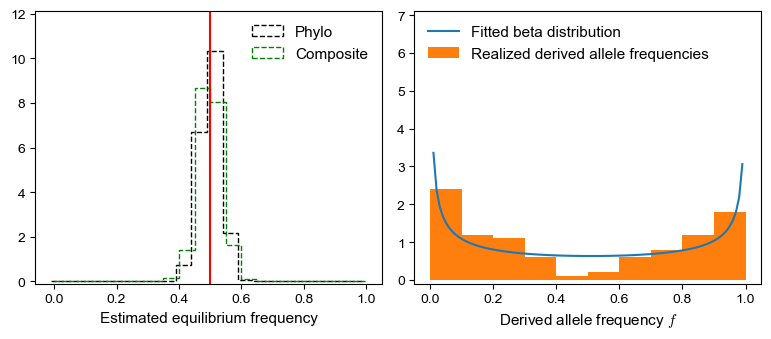

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# standard error
ax[0].hist(bs[:,0], bins=np.linspace(-0.01,0.99,21), density=True, edgecolor='black', histtype=u'step', ls='--', label='Phylo')
ax[0].hist(bs[:,1], bins=np.linspace(0,1,21), density=True, edgecolor='green', histtype=u'step', ls='--', label='Composite')
ax[0].legend(frameon=False, fontsize=11)
ax[0].axvline(0.5, color='red')
ax[0].set_xlabel("Estimated equilibrium frequency", fontsize=11)
ax[0].set_ylim([-.1, 12.1])

# beta fit
x = np.linspace(0, 1, 100)
pdf = beta.pdf(x, a, b)

ax[1].plot(x, pdf, label='Fitted beta distribution')
ax[1].hist(arr.mean(axis=1), density=True, label='Realized derived allele frequencies', bins=np.linspace(0,1,11))
ax[1].legend(loc=2, frameon=False, fontsize=11)
ax[1].set_xlabel(r"Derived allele frequency $f$", fontsize=11)
ax[1].set_ylim([-.1, 7.1])

plt.tight_layout()
plt.savefig('figure6.eps', bbox_inches='tight')
plt.show()